# Density Uncertainty Layer

In [1]:
%%capture
%pip install lightning-uq-box

## Theoretic Foundation

The Density Uncertainty Layer were proposed by [Park and Blei 2024](https://arxiv.org/abs/2306.12497).


## Imports

In [22]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DensityLayerModelRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [52]:
dm = ToyHeteroscedasticDatamodule(n_points=750)

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

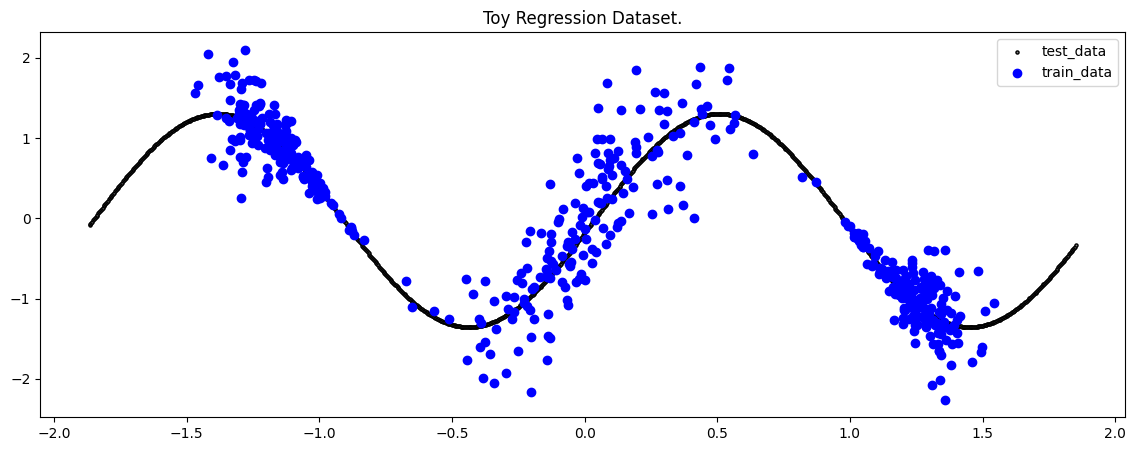

In [53]:
fig = plot_toy_regression_data(X_train, Y_train, X_gtext, Y_gtext)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [54]:
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. The implementation will convert the appropriate layers to Density layers.

In [55]:
density_model = DensityLayerModelRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), num_samples_test=5
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [56]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=400,  # number of epochs we want to train
    accelerator="cpu",  # use distributed training
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [57]:
trainer.fit(density_model, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 13.2 K
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

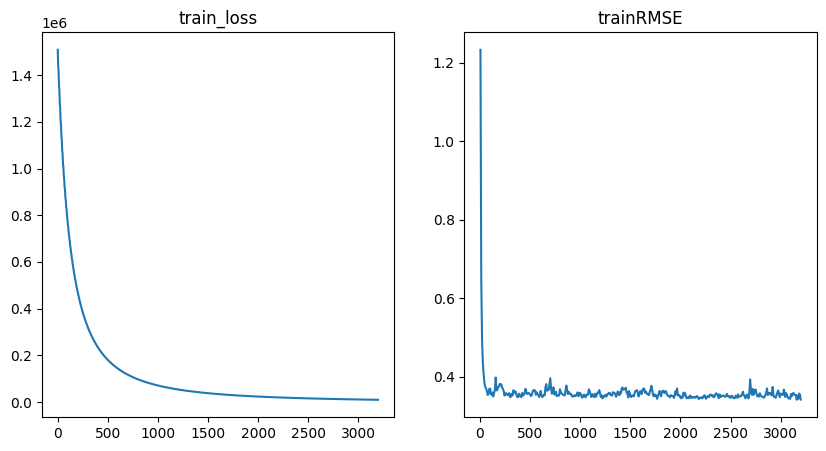

In [58]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Evaluate Predictions

The constructed Data Module contains two possible test variable. `X_test` are IID samples from the same noise distribution as the training data, while `X_gtext` ("X ground truth extended") are dense inputs from the underlying "ground truth" function without any noise that also extends the input range to either side, so we can visualize the method's UQ tendencies when extrapolating beyond the training data range. Thus, we will use `X_gtext` for visualization purposes, but use `X_test` to compute uncertainty and calibration metrics because we want to analyse how well the method has learned the noisy data distribution.

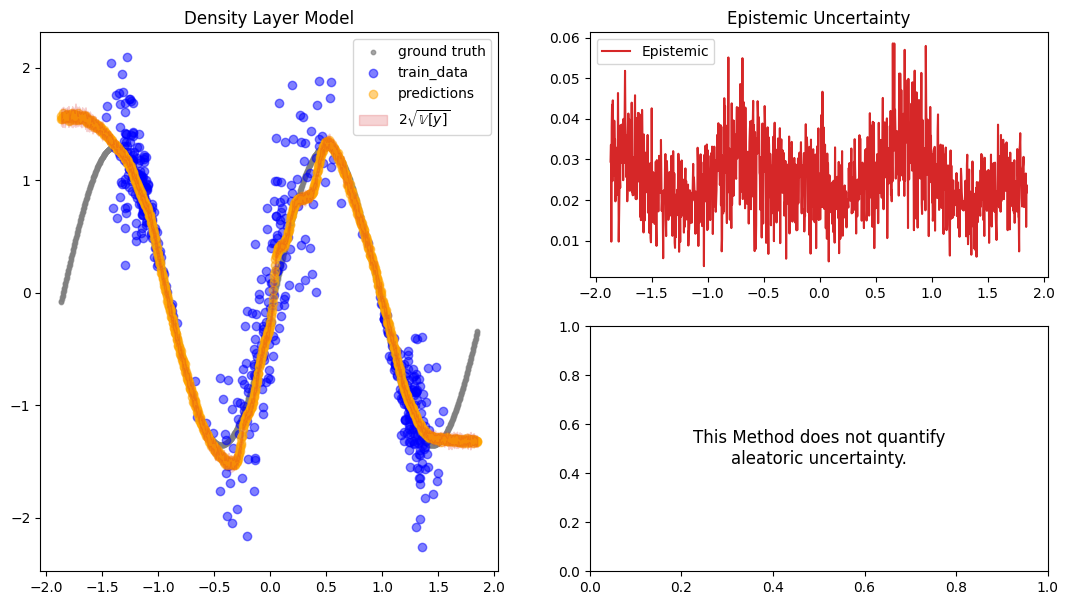

In [59]:
preds = density_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    # aleatoric=preds["aleatoric_uct"],
    epistemic=preds["epistemic_uct"],
    title="Density Layer Model",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction, that we can evaluate on our held out IID test set.

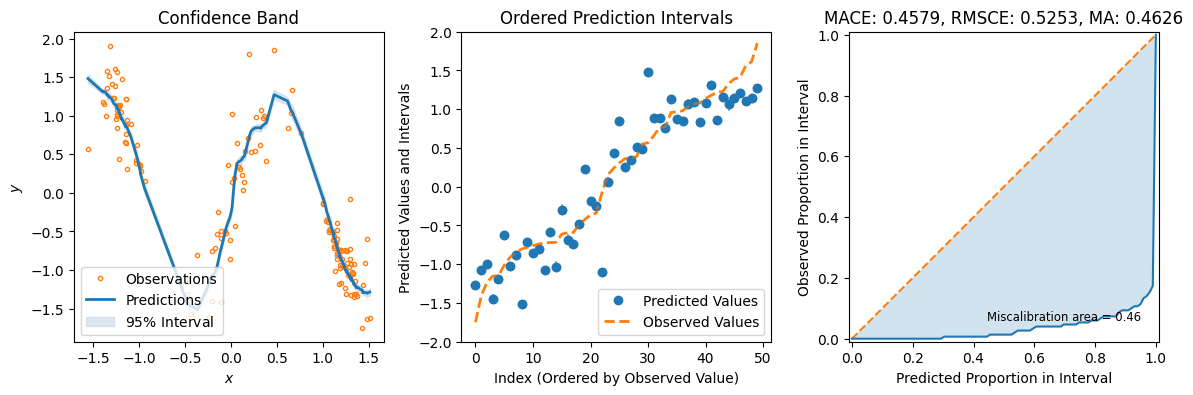

In [60]:
preds = density_model.predict_step(X_test)

fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)